# Определение стоимости автомобилей

# Содержание

**[1. Загрузка и изучение данных](#step1)**

**[2. Подготовка данных](#step2)**

**[3. Анализ модели](#step3)**

**[4. Вывод](#step4)**



Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка и изучение данных

<div style="border:solid green 3px; padding: 20px">

<b>
Загрузим и изучим данные.</b>



In [1]:
!pip install category_encoders

In [2]:
!pip install --upgrade pip

In [3]:
!pip install --upgrade catboost

In [4]:
# Установка необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from category_encoders import *
from time import time
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [6]:
df = pd.read_csv('datasets/autos.csv')
display(df.info())
df.head()

Признаки   
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
Целевой признак  
Price — цена (евро)  


In [7]:
# Смотрим дубликаты
df.duplicated().sum()

<div style="border:solid green 3px; padding: 20px">

<b>
Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, удалим их.  
Подготовим выборки для обучения моделей. </b>



In [8]:
# Удаляем дубликаты
df = df.drop_duplicates().reset_index(drop=True) 

Преобразуем столбцы 'DateCrawled', 'DateCreated' и 'LastSeen' в формат datetime.

Пройдем по каждому столбцу и используем функцию pd.to_datetime() для преобразования значений в формат datetime. Указанный формат '%Y-%m-%d %H:%M:%S' соответствует шаблону даты и времени в столбцах, которые нужно преобразовать.

In [9]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')


Мы изменили тип колонок, связанные со временем, но колонки RegistrationMonth и RegistrationYear мы отнесем к численным признакам, которые могут помочь модели обучения.

Создадим списки колонок, чтобы рассмотреть все характеристики столбцов:

In [10]:
num_cols = []
date_cols = []
cat_cols = []

for i in range(len(df.columns)):
    if df.dtypes[i] == 'int64':
        num_cols.append(df.columns[i])
    elif df.dtypes[i] == 'datetime64[ns]':
        date_cols.append(df.columns[i])
    else:
        cat_cols.append(df.columns[i])
        
print(num_cols, '\n',date_cols, '\n', cat_cols)

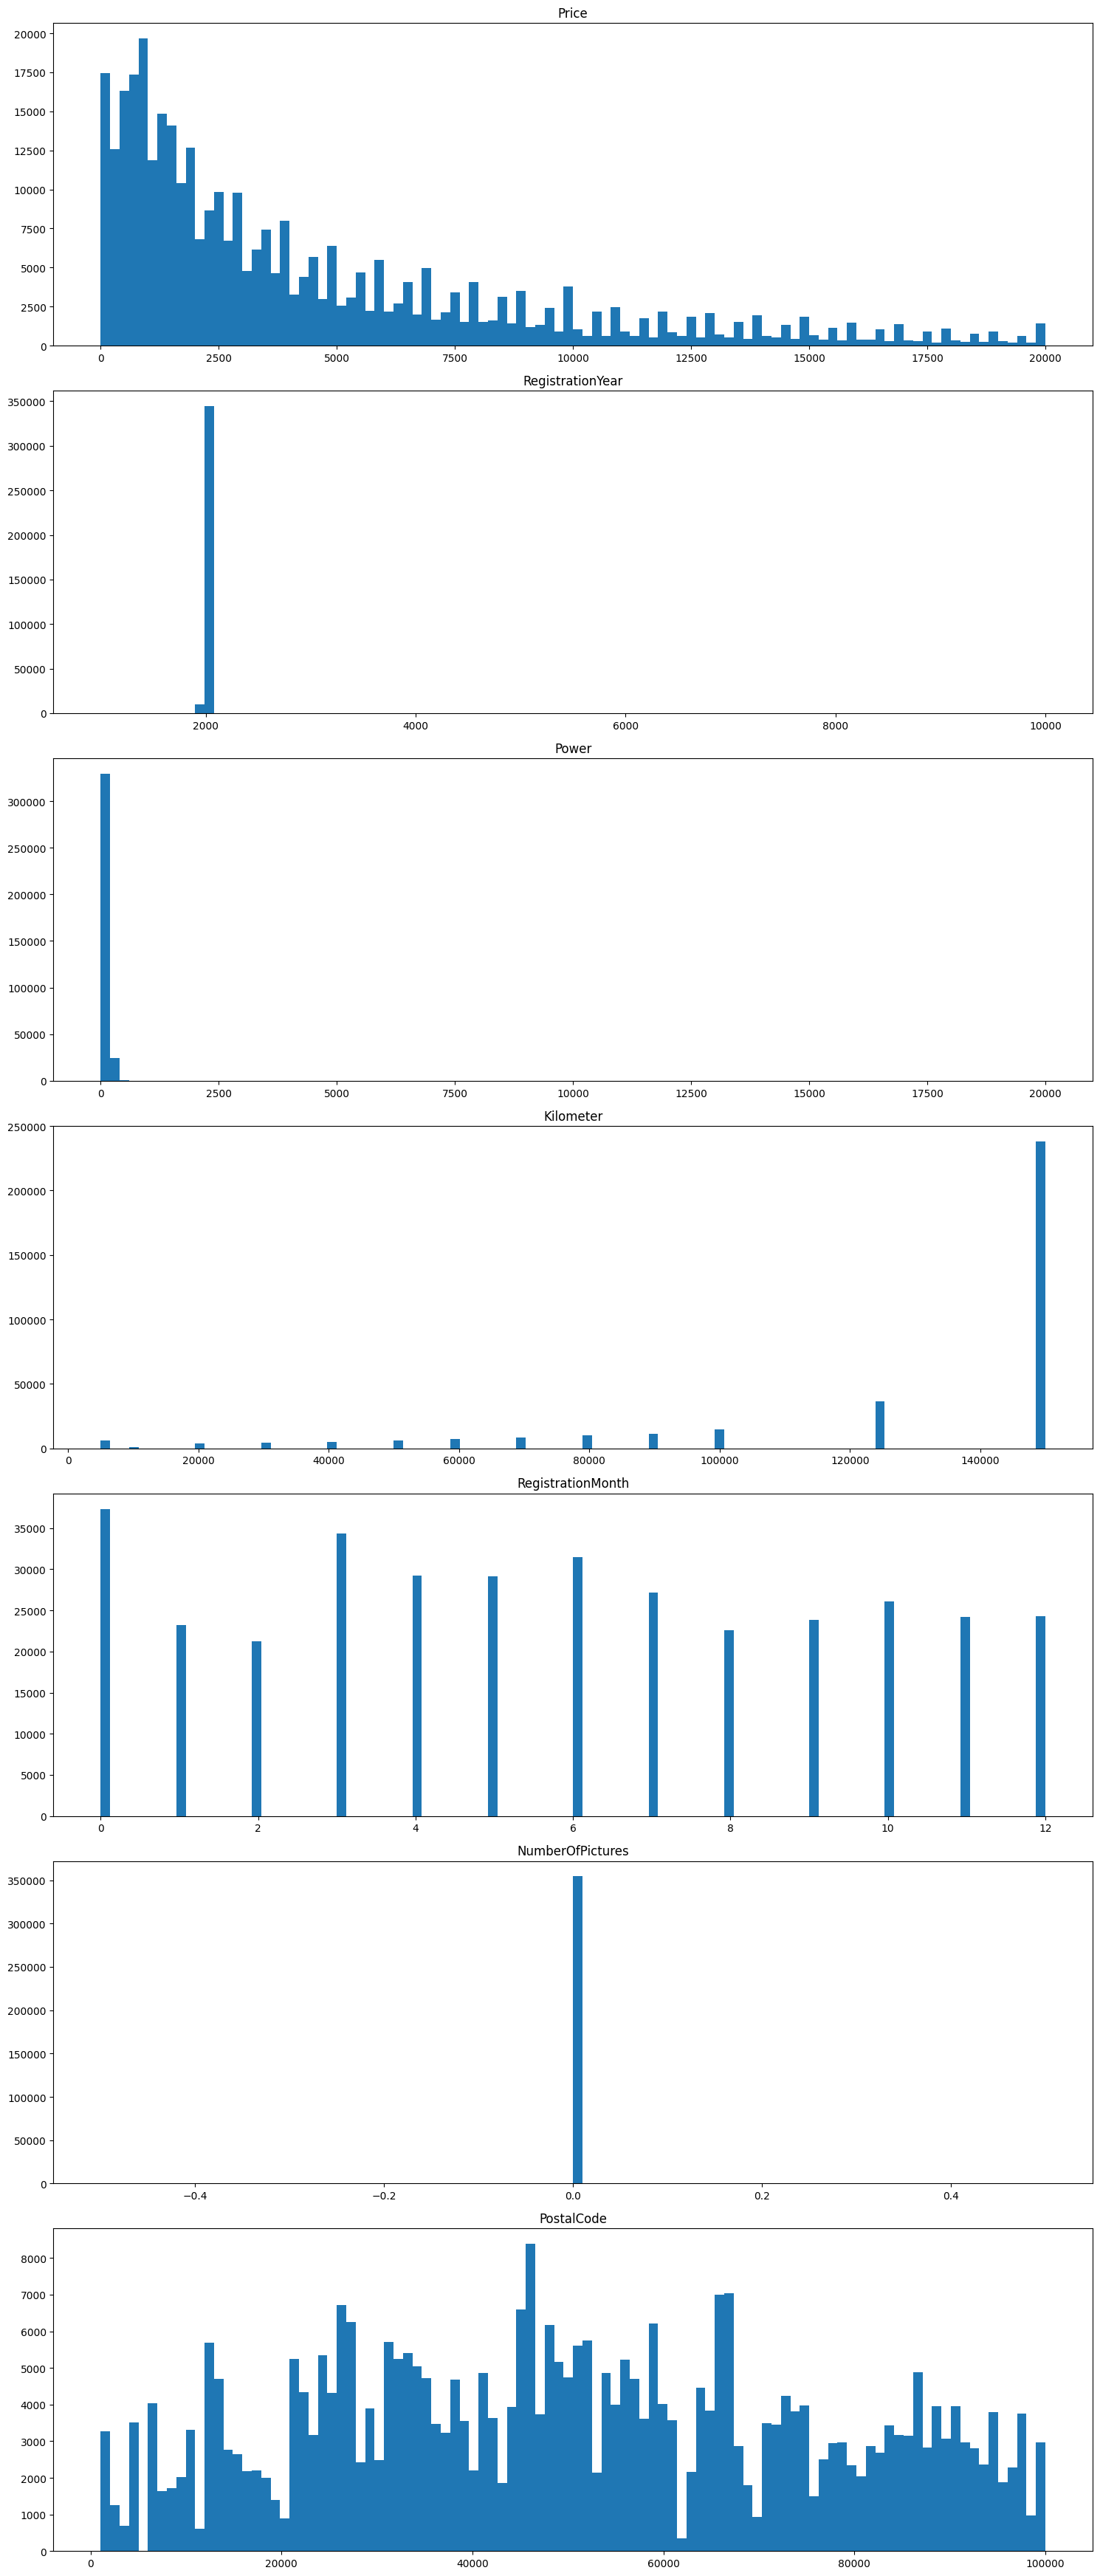

In [11]:
# Создадим гистограммы столбцов
fig, axes = plt.subplots(len(num_cols), 1, figsize=(15, 5 * len(num_cols)))

for i, column in enumerate(num_cols):
    axes[i].hist(df[column], bins=100)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

Используем цикл для получения индекса и значения столбцов num_cols. Также используем subplots для создания сетки графиков, что позволит отображать все графики в одном окне.


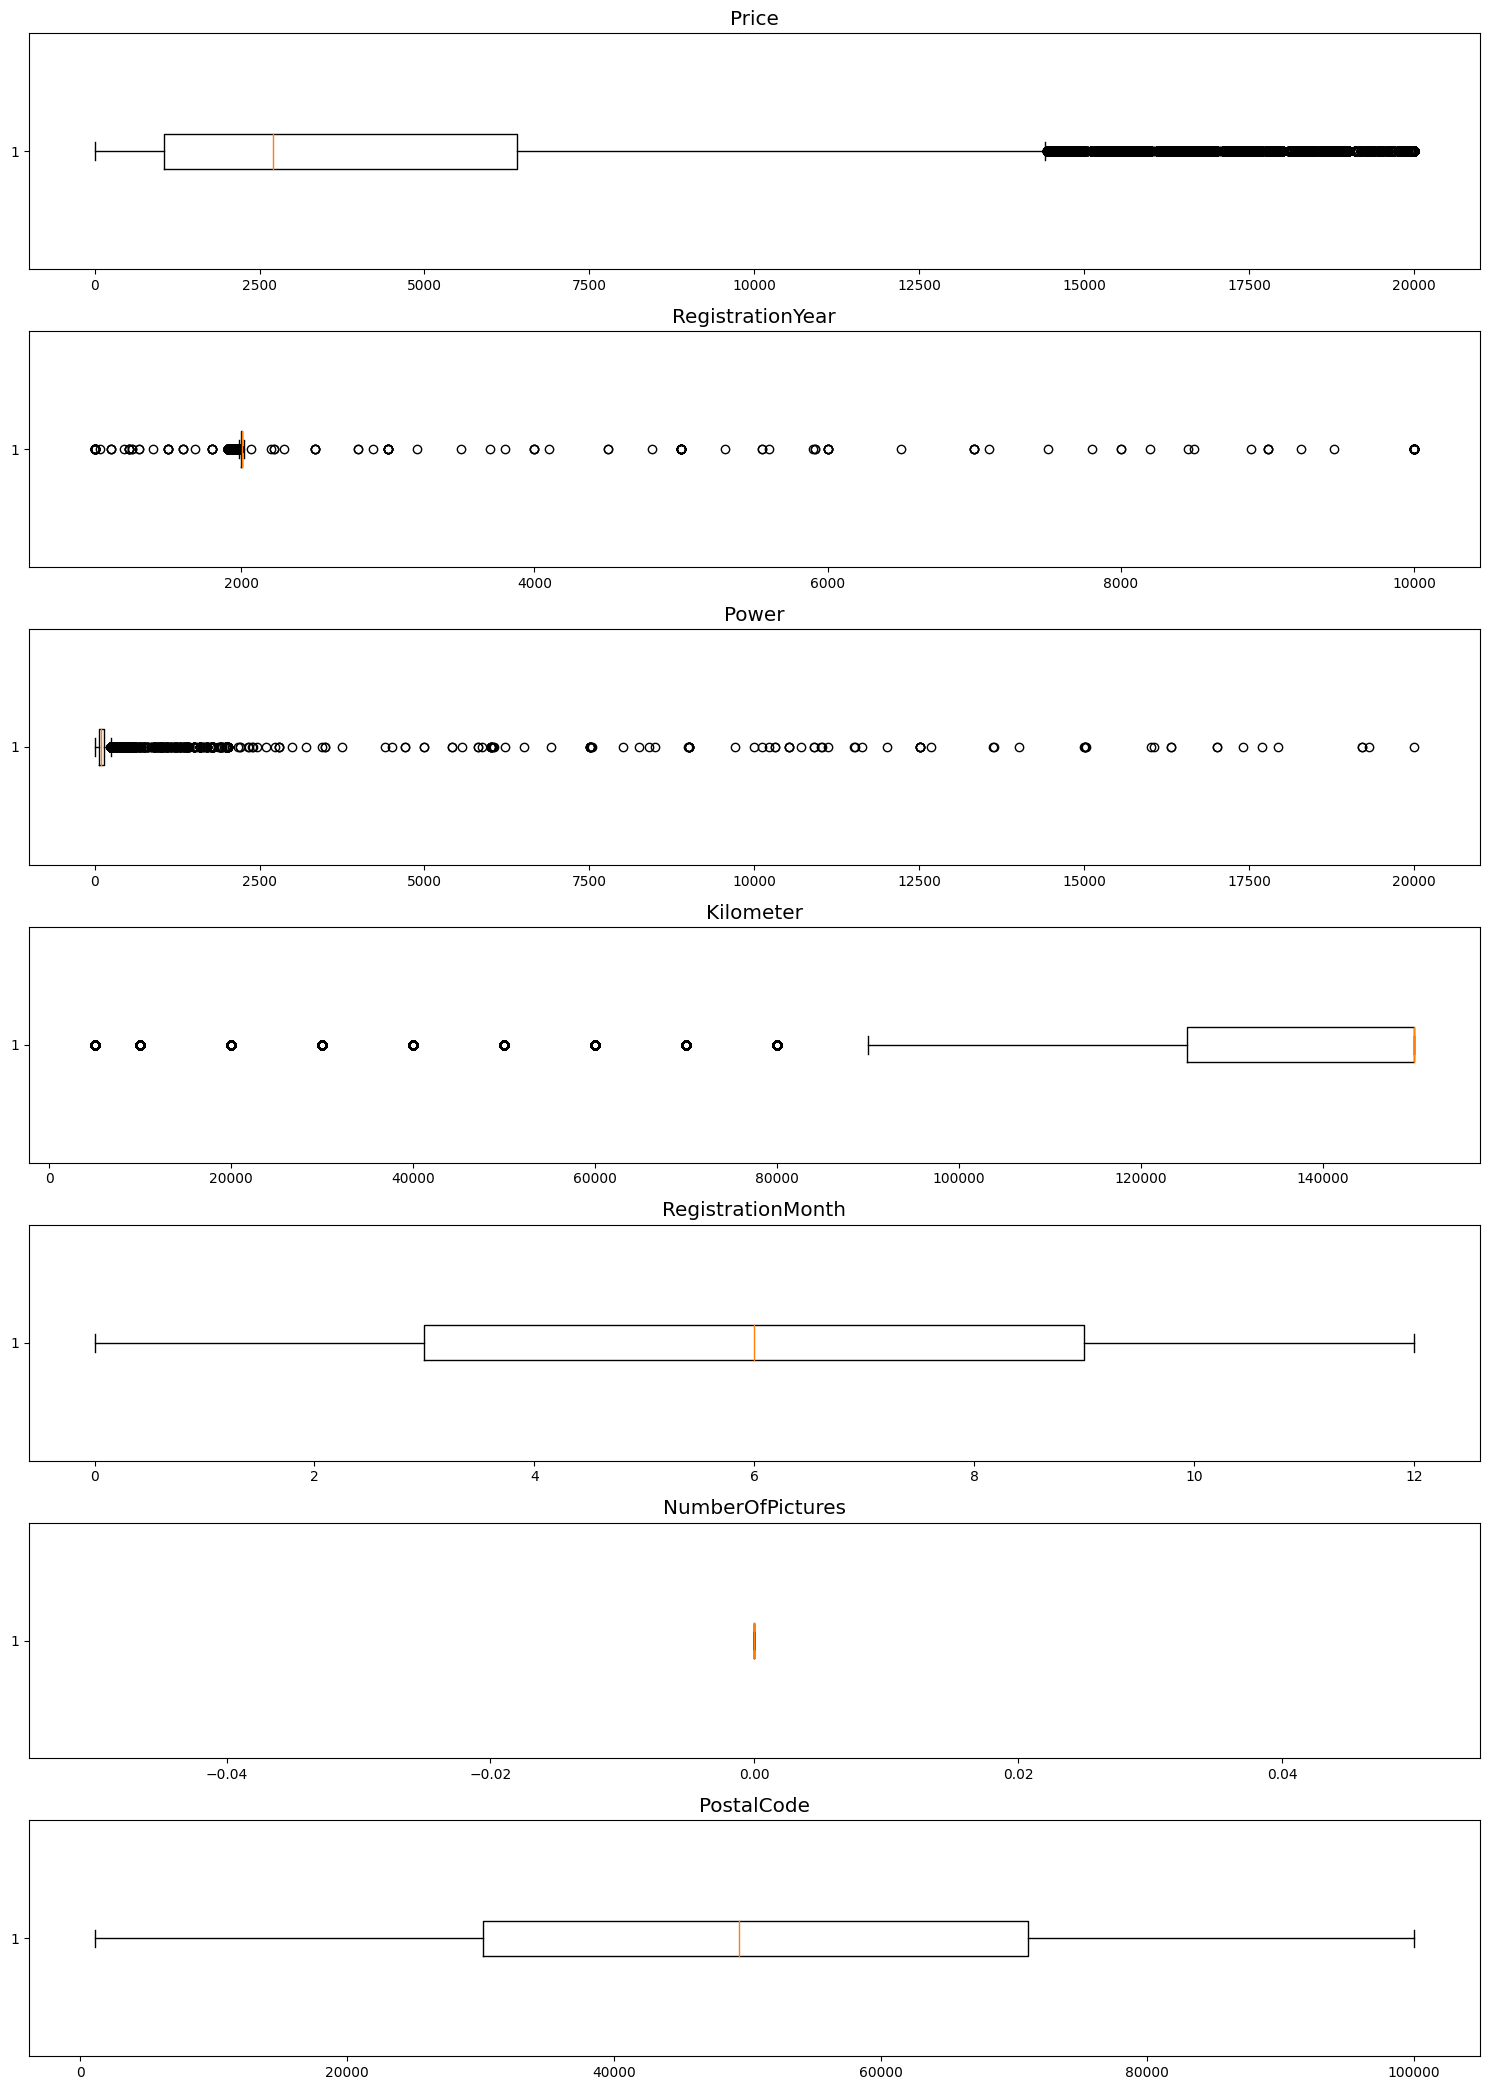

In [12]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(15, 3 * len(num_cols)))

for i, col in enumerate(num_cols):
    axes[i].boxplot(df[col], vert=False)
    axes[i].set_title(col, fontsize='x-large')

plt.tight_layout()
plt.show()

Оценим распределение категориальных столбцов.

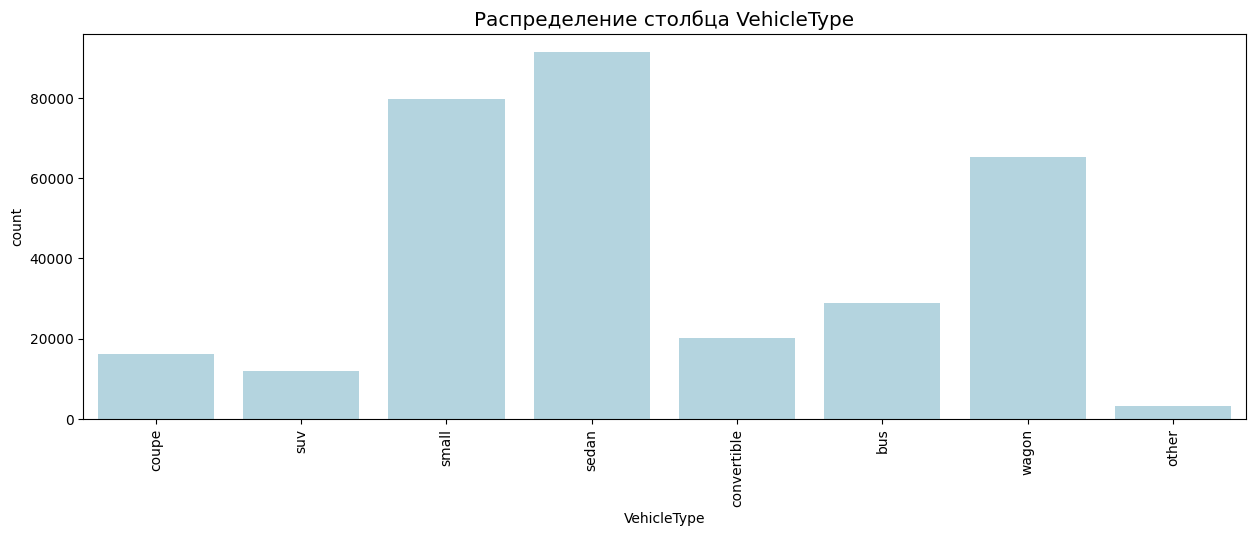

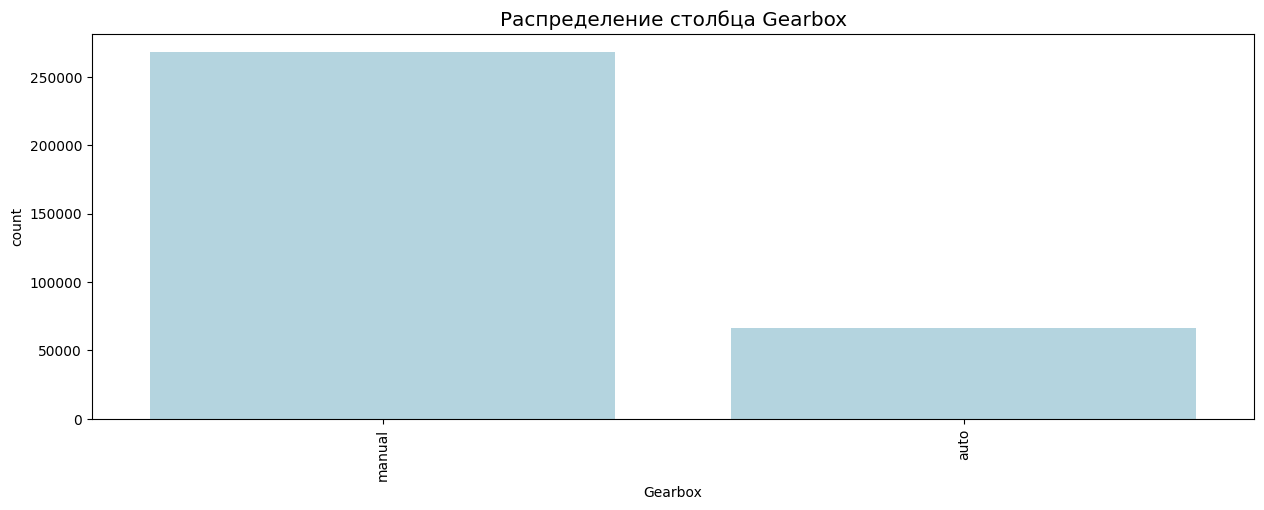

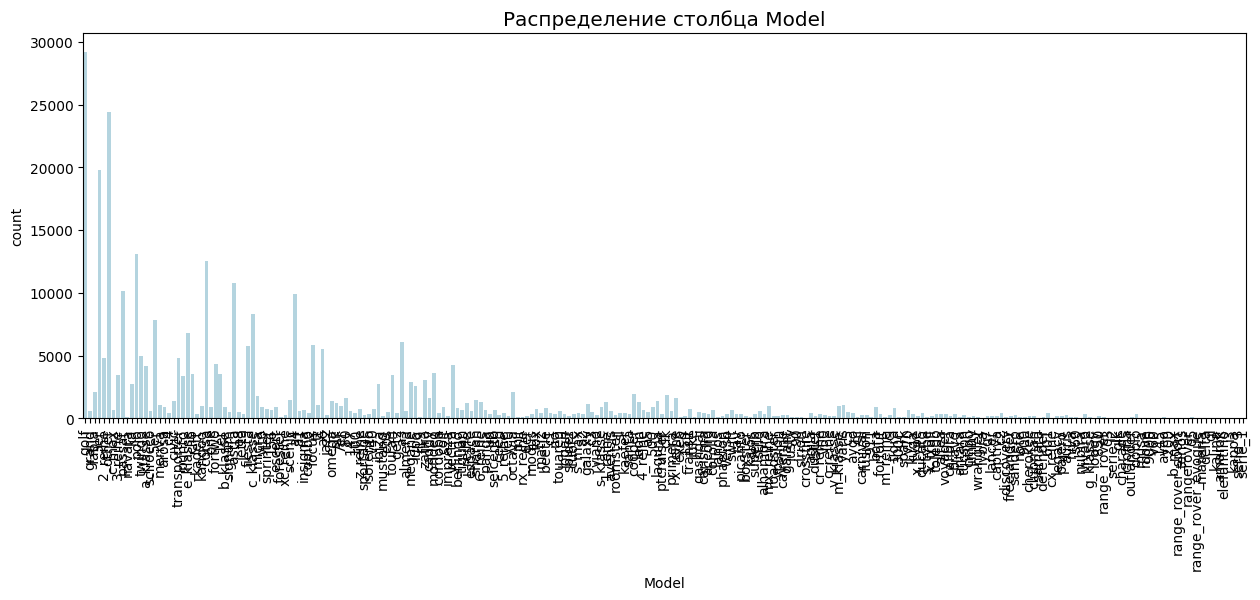

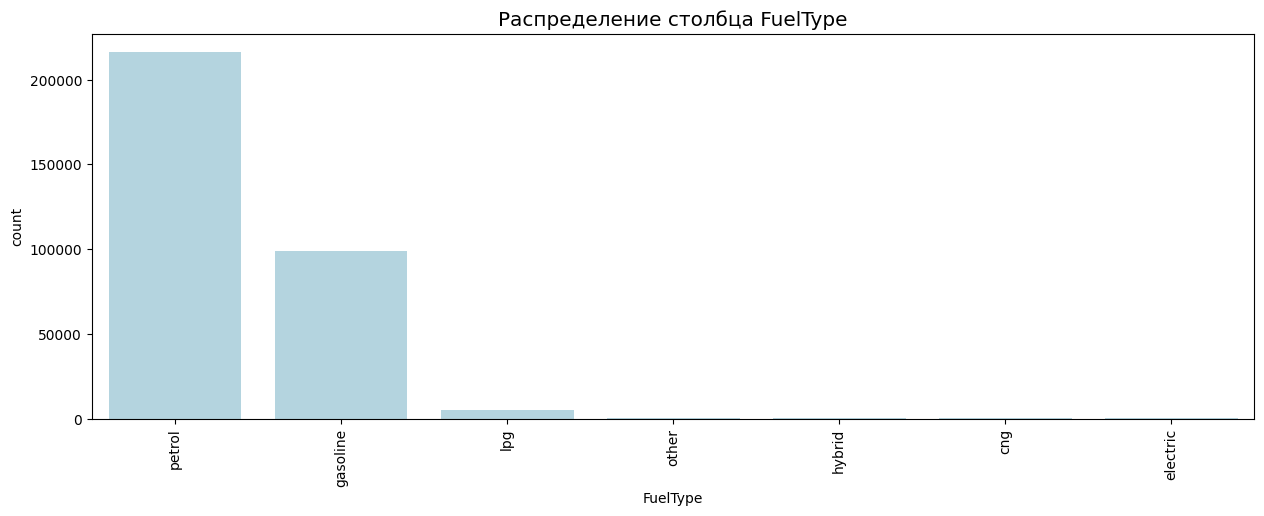

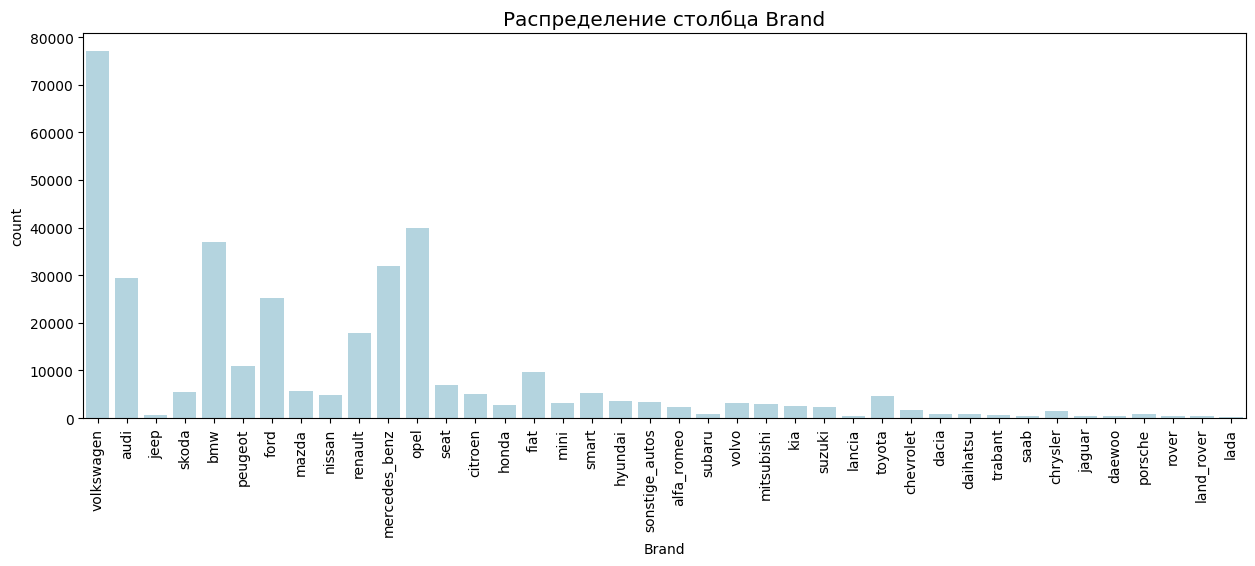

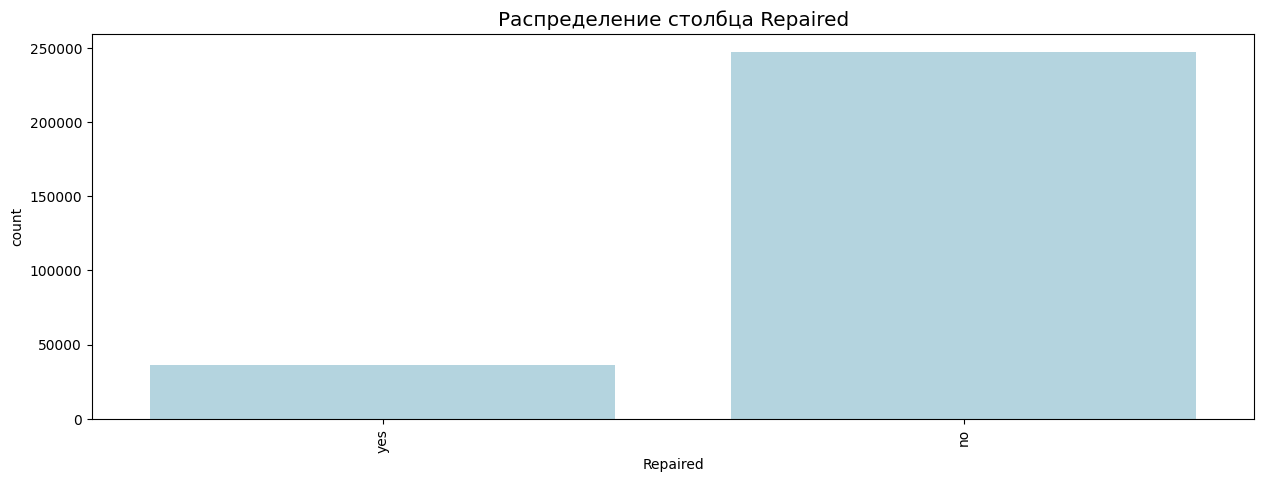

In [13]:
for column in cat_cols:
    plt.figure(figsize=(15, 5))
    sns.countplot(data=df, x=column, color='lightblue')
    plt.title(f'Распределение столбца {column}', fontsize='x-large')
    plt.xticks(rotation=90)
    plt.show()

In [14]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())
    print('Количество пропусков в каждом столбце')    
    print(data_frame.isna().mean()*100)
show_rows(df)

Выводы:  
В данных наблюдаются выбросы в некоторых столбцах, которые имеют очень странный характер. Вероятно, это является артефактами или ошибками в данных. 

Также обнаружены пропуски значений в категориальных столбцах, в то время как численные столбцы не содержат пропусков.  

Столбец, отражающий количество фотографий, содержит только нулевые значения. Возможно, в данных произошла ошибка, и значения не были правильно заполнены.  

Чтобы избежать удаления большого количества строк с пропущенными значениями, предлагается заполнить все пропущенные значения в категориальных столбцах значением "unknown". Это позволит сохранить данные и избежать потери информации.  

In [15]:
df = df.fillna('unknown')

In [16]:
df.head(5)

Рассмотрим артефакты:

Benz Patent-Motorwagen (с нем. «патентованный автомобиль Бенца») — первый в мире автомобиль с двигателем внутреннего сгорания (как и автомобиль Даймлера), построенный в 1885 году немецким изобретателем Карлом Бенцем. 29 января 1886 года на него официально был получен патент №37435.
 Допустим, у нас в датафрейме присутствуют автомобили класса ретро. Все, что ниже этой даты, будем считать артефактами.

In [17]:
# С помощью метода query(), применим условие фильтрации к столбцу RegistrationYear
filtered_df = df.query('RegistrationYear < 1885 or RegistrationYear >= 2022')
# Используем функцию display() для вывода на экран двух частей df
display(filtered_df.head(), filtered_df.tail())
# Выводим кол-во строк
print(f"Количество строк: {filtered_df.shape[0]}")

На сегодняшний день самым мощным легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC. Только представьте: мощность его двигателя превышает 2000 лошадиных сил (2028 л. с.). Допустим, что у нас есть такого класса автомобили. Фильтруем!

In [18]:
filtered_df_2 = df.query('Power >= 2000')

print(f"Количество строк: {filtered_df_2.shape[0]}")


В двух столбцах замечены выбросы, которые могут повлиять на модель при обучении.

Соотвественно, удалим лишние строки с выбросами в годах. Их всего 171.

И также очистим строки с мощностью машин более 2000 л.с - 124 строки.



In [19]:
df = df.drop(df.query('Power >= 2000').index).reset_index(drop=True)
df = df.drop(df.query('RegistrationYear < 1885 or RegistrationYear >= 2022').index).reset_index(drop=True)



df.info()

Эти признаки удалим, они нам не понадобятся:  
DateCrawled — дата скачивания анкеты из базы    
DateCreated — дата создания анкеты  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
NumberOfPictures — количество фотографий автомобиля   
LastSeen — дата последней активности пользователя  

In [20]:
#Удалим столбцы которые нам не понадобятся
df=df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)
df.head(5)



Прежде чем приступить к обучению моделей, необходимо подготовить данные для обработки. Для этого выполним следующие шаги:  
- Применим метод OHE (One-Hot Encoding) только к признакам, где имеется небольшое количество уникальных значений. Признак Model не будет включен в этот процесс.
- Разделим выборку на тренировочную и тестовую части.
- Заменим значения 0 в целевом признаке на тренировочной выборке.
- Обучим модель TargetEncoder на признаке Model, используя тренировочную выборку, а затем применим эту модель как для тренировочной, так и для тестовой выборок.
- Применим стандартизацию к признакам.
- Добавим в тренировочную и тестовую выборки столбцы, полученные в результате OHE, чтобы количество признаков было согласовано.

## Подготовка данных

<div style="border:solid green 3px; padding: 20px">

<b>
Подготовим выборки для обучения моделей. </b>


Наша задача сейчас, создать новый датафрейм df_ohe, содержащий исходные столбцы из df, а также новые столбцы, представляющие фиктивные переменные для категориальных столбцов. В итоге, количество столбцов в df_ohe будет больше, чем в исходном датафрейме df, поскольку каждая категория будет представлена отдельным столбцом с бинарными значениями.


In [21]:
# Удаляем нужный столбец из категорий для обработки
cat_cols.remove('Model')

In [22]:
# Создаем при помощи one-hot encoding фиктивные переменные для категориальных столбцов cat_cols в DataFrame.
df_ohe = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_ohe.info()

Так как мы будем заменять нули на тренировочной выборке, стоит разделить на начальном датасете и выполнить предобработку:

In [23]:
train, test = train_test_split(df,
                               test_size=0.20,
                               random_state=12345)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Заменим нули на трейне на пустые значения для заполнения:

In [24]:
train['Price'] = train['Price'].replace(0, np.nan)

train['Price'].isna().sum()


Выполним заполнение пропущенных значений в столбце 'Price' медианными значениями для каждой группы, сгруппированной по 'RegistrationYear' и 'Brand'. Затем выводем строки, в которых значение столбца 'Price' остается пропущенным. Это может быть полезно для идентификации строк с пропущенными значениями после выполнения заполнения.

In [26]:
train = train.dropna(subset=['Price'])

print(train[train['Price'].isna()])

Видим три раритетных машины, где цена была указана 0, удаляем

In [28]:
train = train.dropna()

Выполним кодирование категориальной переменной 'Model' с использованием TargetEncoder, обученного на данных обучающего набора. Кодированные значения заменяют исходные значения в столбцах 'Model' в обучающем и тестовом наборах. Это позволит использовать информацию о целевой переменной при кодировании категориальной переменной, что может может помочь модели лучше улавливать зависимости и улучшить предсказания.

In [29]:
# Создаем переменную класса TargetEncoder()
target_en = TargetEncoder()
# Вызываем метод fit() на объекте target_en, чтобы выполнить обучение кодировщика на основе данных обучающего набора
target_en.fit(train['Model'], train['Price'])
train['Model'] = target_en.transform(train['Model'])
test['Model'] = target_en.transform(test['Model'])

Объединим данные, чтобы приступить к обучению модели:


In [30]:
# С помощью функции pd.concat() объединяем train и df_ohe.drop(train.columns.drop(cat_cols), axis=1)
train = pd.concat([train, df_ohe.drop(train.columns.drop(cat_cols), axis=1)], 
                  join='inner', 
                  axis=1)
# С помощью функции pd.concat() объединяются test и df_ohe.drop(test.columns.drop(cat_cols), axis=1)
test = pd.concat([test, df_ohe.drop(test.columns.drop(cat_cols), axis=1)], 
                 join='inner', 
                 axis=1)
# C помощью метода drop() удаляем из датафрейма test все столбцы, которые не являются категориальными переменными (cat_cols)
train = train.drop(cat_cols, axis=1)
test = test.drop(cat_cols, axis=1)

print('Размер тренировочной выборки:', train.shape,
      '\nРазмер тестовой выборки:', test.shape)

Применим стандартизацию:    
Только применять мы ее будем исключительно к числовым признакам. Это предотвратит возможные ошибки, если столбцы уже имеют тип данных float или были предварительно обработаны.

Хорошей практикой является разделение предварительной обработки данных на обучающую и тестовую выборки, чтобы избежать влияния информации из тестовой выборки на процесс обучения. Поэтому мы будем выполнять обучение StandardScaler на обучающей выборке и применять его на обучающей и тестовой выборках отдельно.



In [31]:
train_features = train.drop('Price', axis=1)
train_target = train['Price']

test_features = test.drop('Price', axis=1)
test_target = test['Price']

num_cols = ['Kilometer', 'Power', 'RegistrationYear', 'RegistrationMonth']

# Применяем стандартизацию только к числовым признакам
num_train_features = train_features[num_cols]
num_test_features = test_features[num_cols]

scaler = StandardScaler()
scaler.fit(num_train_features)

train_features[num_cols] = scaler.transform(num_train_features)
test_features[num_cols] = scaler.transform(num_test_features)

In [32]:
df.info()


**Вывод:**


Мы провели обширную предобработку данных, которая включила в себя заполнение пропущенных значений, удаление неинформативных признаков и подготовку выборок для обучения моделей.  
В процессе заполнения пропусков в данных мы использовали различные методы.  
Для столбца 'Price' мы удалили записи с пропущенными значениями, так как эти записи не могут быть использованы для обучения моделей.   
Категориальный признак 'Model' мы закодировали с помощью TargetEncoder, обученного на данных обучающего набора. Это позволит моделям использовать информацию о целевой переменной при обучении.   
Также мы применили стандартизацию StandardScaler к числовым признакам, чтобы привести их к одному масштабу перед обучением моделей.

Теперь данные готовы для обучения моделей и дальнейшего анализа.    

## Обучение моделей

<div style="border:solid green 3px; padding: 20px">

<b>
Обучим разные модели, одна из которых — LightGBM. Для каждой модели попробуем разные гиперпараметры.
Проанализируем время обучения, время предсказания и качество моделей.  
Опираясь на критерии заказчика, выберем лучшую модель, проверем её качество на тестовой выборке.  
Примечания:  
Для оценки качества моделей применим метрику RMSE.   </b>


Воспользуемся несколькими библиотеками и моделями машинного обучения:  

Линейная регрессия  
Дерево решений  
Случайный лес  
Градиентный бустинг  
Такими библиотеками, как:  

sklearn  
XGBoost  
LightGBM  
CatBoost  

Делим выборки:

In [33]:
train_features, valid_features, train_target, valid_target = train_test_split(train_features, 
                                                                              train_target,
                                                                              test_size=0.25,
                                                                              random_state=12345)


Приступим к обучению модели:

In [34]:
lnr = LinearRegression()

start = time()
lnr.fit(train_features, train_target)
predicted = lnr.predict(valid_features)
lnr_time_fit = time() - start

print('Время обучения модели: {:0.2f} секунд'.format(lnr_time_fit),
      '\nRMSE на валидационной выборке:', mean_squared_error(valid_target, predicted, squared=False))

Вывод:

После обработки данных, метрика качества на RMSE на валидационной выборке: 2820.20.

Время предсказания модели: 0.19 секунд.

Сравним деревянные модели и сделаем вывод

Удалим заранее переменные, которые нам больше не понадобятся:

In [35]:
del df_ohe

Для использования RandomizedSearchCV - объединим назад наши выборки. RandomizedSearchCV - это инструмент для подбора оптимальных гиперпараметров модели машинного обучения с использованием случайного поиска. Он является частью библиотеки scikit-learn и предоставляет функциональность для автоматизации процесса подбора гиперпараметров.

RandomizedSearchCV выполняет случайное исследование пространства гиперпараметров модели, выбирая случайным образом комбинации значений гиперпараметров из заданного набора. Затем он оценивает модель с использованием выбранной комбинации гиперпараметров и сохраняет результаты оценки. После выполнения определенного числа итераций (заданного пользователем) он возвращает лучшие найденные значения гиперпараметров, основываясь на заданной метрике оценки.

Это позволяет автоматизировать и упростить процесс подбора гиперпараметров, исследуя широкий диапазон значений с использованием случайных комбинаций. Это особенно полезно, когда пространство гиперпараметров большое или неизвестно, какие значения будут наиболее эффективными для модели.

In [36]:
train_features = pd.concat([train_features, valid_features])
train_target = pd.concat([train_target, valid_target])


Для подбора параметров деревянных моделей будем использовать RandomizedSearchCV, чтобы ускорить вычисления.  

Создадим функцию, которая обучит и вернет модель и метрику:  

In [37]:
# Создаем пустой DataFrame analisys с колонками 'model', 'RMSE' и 'time_to_predict' для результатов анализа моделей
analisys = pd.DataFrame({'model':[], 'RMSE':[], 'time_to_predict':[]})
# Создаем пустой список all_models, в котором будут храниться все обученные модели
all_models = []
# Определяем функцию train_model, которая принимает модель и ее параметры в качестве аргументов
def train_model(model, parameters):
# Внутри функции train_model выполним случайный поиск наилучших параметров модели с помощью RandomizedSearchCV    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=100, 
                                      scoring='neg_mean_absolute_error', # используем необходимую метрику
                                      cv=3, 
                                      verbose=1, 
                                      random_state=12345)
    
    # Посмотрим время обучения с помощью функции time()
    start = time()
    model_random.fit(train_features, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))
    # замеряем и выводим время, затраченное на предсказание модели
    start = time()
    model_random.predict(train_features)
    time_to_predict = time() - start
    print('Модель предсказывает за %.2f секунд' %time_to_predict)
    
    # Вычислим значение RMSE модели с помощью атрибута best_score_ модели model_random
    rmse = model_random.best_score_ * -1 ** 0.5
    # Выводим лучшие параметры модели и значение RMSE обученной модели
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    # Обученная модель model_random и значение RMSE сохраняем в списке all_models и добавляем в DataFrame analisys
    all_models.append(model_random)
    row = []
    row.extend([model, rmse, time_to_predict])
    analisys.loc[len(analisys.index)] = row
    # Функция train_model возвращает обученную модель model_random и значение RMSE модели
    return model_random, rmse

Выполним обучение модели Дерево решений и оценим ее производительность. 

In [38]:
# Создаем словарь ran_grid_tree 
ran_grid_tree = {
    'max_depth': [15]
}
# Инициализируем модель DecisionTreeRegressor 
dtr = DecisionTreeRegressor()
# Возвращаем два значения: dtr_random - обученную модель DecisionTreeRegressor и rmse_dtr - значение метрики RMSE
dtr_random, rmse_dtr = train_model(dtr, ran_grid_tree)

Случайный лес

In [39]:
# Создаем словарь ran_grid_forest

ran_grid_forest = {
    'max_depth': [11, 12, 13],
    'n_estimators': [100, 200, 300]
}
# Инициализируем модель RandomForestRegressor
rfr = RandomForestRegressor(n_jobs=-1)

rfr_random, rmse_rfr = train_model(rfr, ran_grid_forest) # обучим и сохраним значения

ran_grid_forest = {
    'max_depth': [11, 12, 13],
    'n_estimators': [100, 200, 300]
}

rfr = RandomForestRegressor(n_jobs=-1)
# Возвращаем два значения
rfr_random, rmse_rfr = train_model(rfr, ran_grid_forest)

LightGBM:

In [40]:
# Создаем словарь 
rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25, 35],
    'learning_rate': [0.01, 0.1, 0.15]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')
# Возвращаем два значения
gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param)

XGBoost:



In [41]:
# Создаем словарь 
rand_xgb_param = {
    'max_depth': [12, 13, 14, 15],
    'learning_rate': [0.1, 0.15, 0.3]
}

xb = xgb.XGBRegressor(booster='gbtree', 
                      eval_metric='rmse', 
                      use_rmm=True)
# Возвращаем два значения
xb_random, rmse_xb = train_model(xb, rand_xgb_param)

CatBoost:

In [42]:
# Создаем словарь 
rand_cat_param = {
    'max_depth': [8, 9, 10, 11],
    'learning_rate': [0.01, 0.1, 0.2]
}

cat = CatBoostRegressor(verbose=False, 
                        task_type='CPU') 
# Возвращаем два значения
cat_random, rmse_cat = train_model(cat, rand_cat_param)

## Анализ моделей

Создадим списки для заполнения нашей итоговой таблицы и рассмотрим полученные метрики:

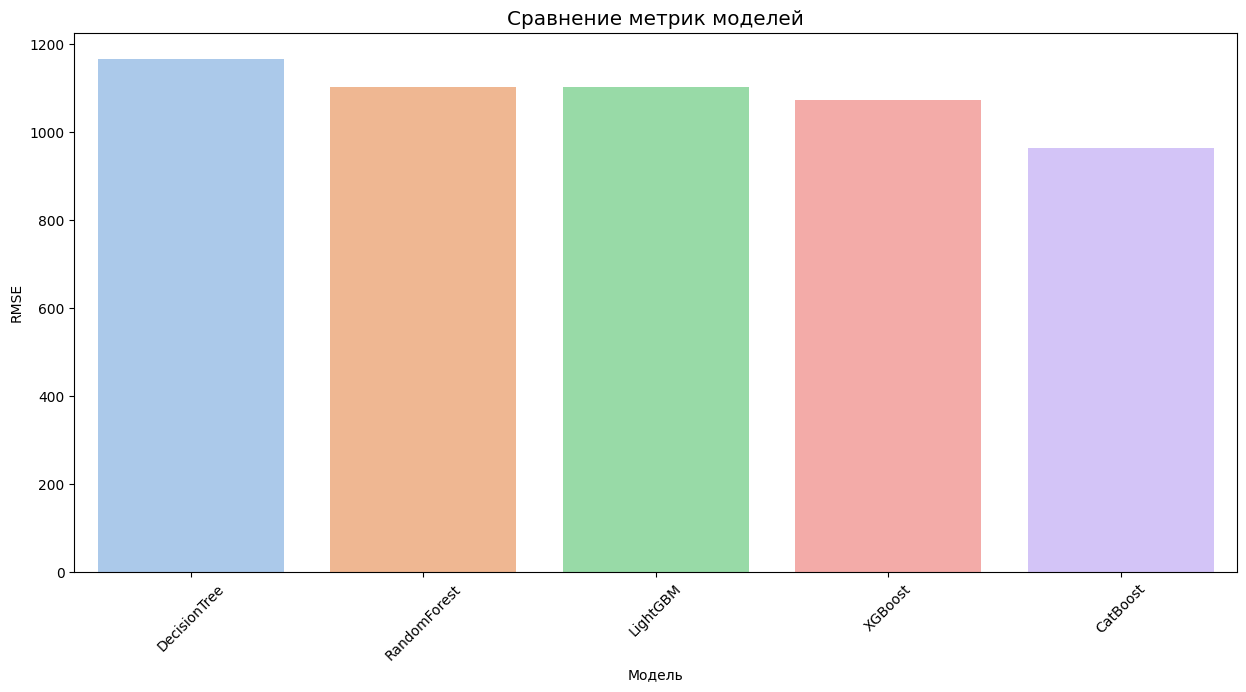

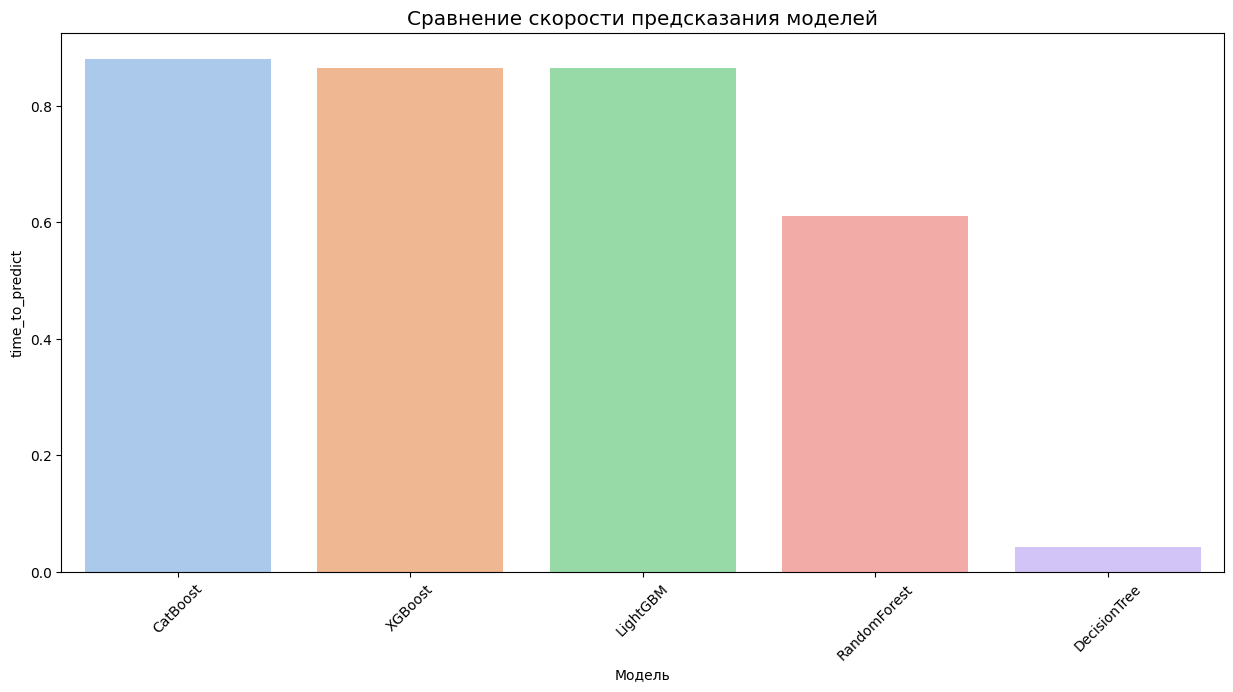

In [43]:
# Задаем пастельность графикам
sns.set_palette("pastel")

all_names = pd.DataFrame({'names':['DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost', 'CatBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
# Вывод таблицы анализа моделей
display(analisys)

# График сравнения метрик моделей
plt.figure(figsize=(15, 7))
sns.barplot(data=analisys, x='names', y='RMSE')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.xticks(rotation=45)
plt.show()

# График сравнения скорости предсказания моделей
plt.figure(figsize=(15, 7))
sns.barplot(data=analisys.sort_values(by='time_to_predict', ascending=False), x='names', y='time_to_predict')
plt.title('Сравнение скорости предсказания моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.xticks(rotation=45)
plt.show()


Из проведенного анализа моделей следует следующее:

Среди всех деревянных моделей с рандомными параметрами LightGBM обучается быстрее всех. Самой низкой производительностью обладает линейная регрессия.
Модели CatBoost и XGBoost демонстрируют наилучшие метрики качества. Разница между ними незначительна. Однако время обучения этих моделей является самым длительным.
Наиболее оптимальное сочетание времени предсказания и качества модели наблюдается у модели XGBoost.
В результате анализа наиболее рекомендуется выбрать обученную модель XGBoost для дальнейшего использования.

Необходимо измерить время предсказания модели на тестовой выборке и вычисляет RMSE для оценки точности модели на тестовых данных.

In [44]:
# Засекаем текущее время с помощью функции time() и сохраняем его в переменную start
start = time()
# Используем обученную модель xb_random для предсказания на тестовой выборке test_features
predicted = xb_random.predict(test_features)
# Вычислим время и выводим время, затраченное на предсказания на тесте
print('Модель предсказывает не тестовой выборке за %.2f секунд' %(time() - start))
# Вычисляем значение RMSE
rmse_on_test = mean_squared_error(test_target, predicted, squared=False)
# Выводим итоговое значение RMSE на тестовой выборке
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Вывод:  


Мы загрузили данные из файла /datasets/autos.csv и изучили их. В процессе обработки данных мы заполнили пропущенные значения и обработали аномалии в столбцах. Неинформативные признаки были удалены из датасета.

Далее мы подготовили выборки для обучения моделей. Мы использовали различные модели, включая LightGBM, а также несколько других моделей, не относящихся к бустингу. Для каждой модели мы экспериментировали с разными гиперпараметрами, чтобы найти наилучшие значения.

Мы проанализировали время обучения, время предсказания и качество моделей. Для оценки качества моделей мы использовали метрику RMSE. Критерием выбора лучшей модели были требования заказчика, и мы выбрали модель, удовлетворяющую этим требованиям. Затем мы проверили качество выбранной модели на тестовой выборке.



В целом, все модели предсказывают довольно быстро, но все же для заказчика важна скорость предсказания и метрика, потому лучшая модель - XGBoost, для которого RandomizedSearchCV подбирал параметры 866.26 секунд, модель предсказывает за 0.88 секунд, лучшие параметры: {'max_depth': 15, 'learning_rate': 0.1}, RMSE обученной модели: 964.1324596613126.